train acc loading | 0.9915254237288136,learning rate:0.1


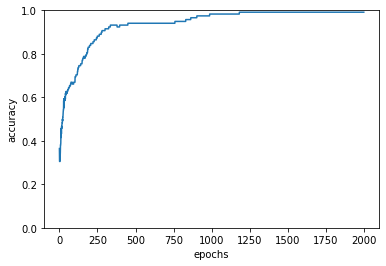

train acc maintenance | 1.0,learning rate:0.1


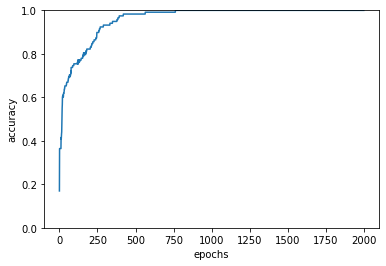

In [1]:
#TEIC-module 5.1 (model construction/trained with whole experts data)

#enter the filepath2 before running the program

filepath1 ="../dataset/TEIC_data(expert_non-ICU)(TEIC-table3).csv" #filepath to the dataset (TEIC-table3)
filepath2 ="" #filepath to the folder where to save the weight parameters

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def one_hot_encoding(x):
    unique = list(np.unique(x))
    for i in unique:
        x = np.where(x == i, unique.index(i), x)
    x = np.ravel(x).astype(int)
    one_hot = np.eye(len(np.unique(x)))[x]
    return unique, one_hot      
                                                                                                                       
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # overflow
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.res

def sigmoid(x):
    return 1 / (1 + np.exp(-x))  

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size).astype(np.float32)
        self.params['b1'] = np.zeros(hidden_size).astype(np.float32)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size).astype(np.float32)
        self.params['b2'] = np.zeros(output_size).astype(np.float32)
        self.h ={}
        self.h['W1'] = np.zeros_like(self.params['W1'])
        self.h['b1'] = np.zeros_like(self.params['b1'])
        self.h['W2'] = np.zeros_like(self.params['W2'])
        self.h['b2'] = np.zeros_like(self.params['b2'])


    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:input, t:output
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:input, t:output
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

data = pd.read_csv(filepath1)
ID = np.array(data[["index"]])
param_list1=["Age","body weight","BMI","Creatinine clearance","Alb","TO"]
param_list2 = ["T1","T2","T3","T4","T5","T6","T7"]
parameter1 = np.array(data[param_list1]).astype(np.float32) #patameter1
parameter2 = np.array(data[param_list2]) #patameter2
loading = np.array(data[["loading dose"]])#loading
loading_dose = np.copy(loading)
maintenance = np.array(data[["maintenance dose"]]) #maintenance
maintenance_dose = np.copy(maintenance)
TDM = np.array(data[["TDM","TDM exclusion criteria"]])

#transform loading to one-hot encoding
ll, loading_one_hot = one_hot_encoding(loading)


#transform maintenance to one-hot encoding
lm, maintenance_one_hot = one_hot_encoding(maintenance)


from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(parameter1)
parameter_scale= sc.transform(parameter1)
parameter = np.concatenate([parameter_scale, parameter2], 1)  

#deep learning for loading
network_loading = TwoLayerNet(input_size=len(param_list1)+len(param_list2), hidden_size=15, output_size=len(np.unique(loading)))

iters_num = 2000  #iteration
j=0.1 #learning rate
learning_rate = j
train_loss_loading_list = []
train_acc_loading_list = []
for i in range(iters_num):
    #grads = network.numerical_gradient(x_batch, t_batch)
    grads = network_loading.gradient(parameter, loading_one_hot)
    #parameter update
    for key in ('W1', 'b1', 'W2', 'b2'):
        network_loading.h[key] += grads[key] * grads[key]
        network_loading.params[key] -= learning_rate * grads[key]/(np.sqrt(network_loading.h[key])+1e-7)
    loss = network_loading.loss(parameter, loading_one_hot)
    train_loss_loading_list.append(loss)    
    train_acc_loading = network_loading.accuracy(parameter, loading_one_hot)
    train_acc_loading_list.append(train_acc_loading)
np.save(str(filepath2)+"/loading.param(W1_whole_non-ICU_lr:{}).npy".format(j), network_loading.params["W1"])
np.save(str(filepath2)+"/loading.param(b1_whole_non-ICU_lr:{}).npy".format(j), network_loading.params["b1"])
np.save(str(filepath2)+"/loading.param(W2_whole_non-ICU_lr:{}).npy".format(j), network_loading.params["W2"])
np.save(str(filepath2)+"/loading.param(b2_whole_non-ICU_lr:{}).npy".format(j), network_loading.params["b2"])
print("train acc loading | " + str(train_acc_loading)+ "," +"learning rate:"+str(j))
#graph
x = np.arange(len(train_acc_loading_list))
plt.plot(x, train_acc_loading_list, label='train acc loading_lr:{}'.format(j))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.show()

#deep learning for maintenance
network_maintenance = TwoLayerNet(input_size=len(param_list1)+len(param_list2), hidden_size=15, output_size=len(np.unique(maintenance)))

iters_num = 2000  #iteration

j = 0.1 #learning rate
learning_rate = j
train_loss_maintenance_list = []
train_acc_maintenance_list = []
for i in range(iters_num):
    #grad = network.numerical_gradient(x_batch, t_batch)
    grads = network_maintenance.gradient(parameter, maintenance_one_hot)
    #parameter update
    for key in ('W1', 'b1', 'W2', 'b2'):
        network_maintenance.h[key] += grads[key] * grads[key]
        network_maintenance.params[key] -= learning_rate * grads[key]/(np.sqrt(network_maintenance.h[key])+1e-7)
    loss = network_maintenance.loss(parameter, maintenance_one_hot)
    train_loss_maintenance_list.append(loss)
    train_acc_maintenance = network_maintenance.accuracy(parameter, maintenance_one_hot)
    train_acc_maintenance_list.append(train_acc_maintenance)
np.save(str(filepath2)+"/maintenance.param(W1_whole_non-ICU_lr:{}).npy".format(j), network_maintenance.params["W1"])
np.save(str(filepath2)+"/maintenance.param(b1_whole_non-ICU_lr:{}).npy".format(j), network_maintenance.params["b1"])
np.save(str(filepath2)+"/maintenance.param(W2_whole_non-ICU_lr:{}).npy".format(j), network_maintenance.params["W2"])
np.save(str(filepath2)+"/maintenance.param(b2_whole_non-ICU_lr:{}).npy".format(j), network_maintenance.params["b2"])
print("train acc maintenance | " + str(train_acc_maintenance) + "," +"learning rate:"+str(j))
#graph
x = np.arange(len(train_acc_maintenance_list))
plt.plot(x, train_acc_maintenance_list, label='train acc maintenance_lr:{}'.format(j))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.show()

In [3]:
#TEIC-module 5.2 (model evaluation)

#enter the filepath4 before running the program

filepath1 ="../dataset/TEIC_data(non-expert_non-ICU)(TEIC-table11).csv" #filepath to the non-expert dataset (TEIC-table11)
filepath2 ="../dataset/TEIC_data(expert_non-ICU)(TEIC-table3).csv" #filepath to the expert dataset(TEIC-table3)
filepath3 ="../weight parameter/external validation (expertML)" #filepath to the folder containing weight parameters
filepath4 ="" #filepath to the folder where to save the result

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def one_hot_encoding(x):
    unique = list(np.unique(x))
    for i in unique:
        x = np.where(x == i, unique.index(i), x)
    x = np.ravel(x).astype(int)
    one_hot = np.eye(len(np.unique(x)))[x]
    return unique, one_hot      
                                                                                                                                                                                                       
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) #overflow
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.res

def sigmoid(x):
    return 1 / (1 + np.exp(-x))  

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:input, t:output
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:input, t:output
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

data = pd.read_csv(filepath1)#non-expert data
data_2 = pd.read_csv(filepath2)#expert data

param_list1=["Age","body weight","BMI","Creatinine clearance","Alb","TO"]
param_list2 = ["T1","T2","T3","T4","T5","T6","T7"]
param_list3 = ["index"]

parameter1 = np.array(data[param_list1]) #patameter1 in non-expert (numerical)
parameter2 = np.array(data[param_list2]) #patameter2 in non-expert (binary)
parameter_model=np.array(data_2[param_list1]) #parameter in expert(numerical)
ID = np.array(data[param_list3])
loading_model = np.array(data_2[["loading dose"]])#experts' loading
maintenance_model = np.array(data_2[["maintenance dose"]]) #experts' maintenance
loading = np.array(data[["loading dose"]])
maintenance = np.array(data[["maintenance dose"]])
TDM = np.array(data[["TDM","TDM exclusion criteria"]])

#transform loading to one-hot encoding
ll, loading_one_hot = one_hot_encoding(loading_model)

#transform maintenance to one-hot encoding
lm, maintenance_one_hot = one_hot_encoding(maintenance_model)


sc = StandardScaler()
sc.fit(parameter_model) #parameter in expert (numerical)
parameter1_scaler = sc.transform(parameter1)
parameter_scaler = np.concatenate([parameter1_scaler, parameter2], 1)

#loading
network_loading = TwoLayerNet(input_size=len(param_list1)+len(param_list2), hidden_size=15, output_size=len(np.unique(loading_model)))

#parameter incorporation
for key in ('W1', 'b1', 'W2', 'b2'):
    network_loading.params[key] = np.load(str(filepath3)+"/loading.param({}_whole_non-ICU_lr_0.1).npy".format(key))
    

pred_loading_one_hot_to_index = list(np.argmax(network_loading.predict(parameter_scaler),axis=1))
pred_loading_dose = np.array([ll[i] for i in pred_loading_one_hot_to_index]).reshape((len(pred_loading_one_hot_to_index), 1))


#maintenance
network_maintenance = TwoLayerNet(input_size=len(param_list1)+len(param_list2), hidden_size=15, output_size=len(np.unique(maintenance_model)))

#parameter incorporation
for key in ('W1', 'b1', 'W2', 'b2'):
    network_maintenance.params[key] = np.load(str(filepath3)+"/maintenance.param({}_whole_non-ICU_lr_0.1).npy".format(key))
    

pred_maintenance_one_hot_to_index = list(np.argmax(network_maintenance.predict(parameter_scaler),axis=1))
pred_maintenance_dose = np.array([lm[i] for i in pred_maintenance_one_hot_to_index]).reshape(len(pred_maintenance_one_hot_to_index), 1)

np_result = np.concatenate([ID, parameter1,parameter2, loading, pred_loading_dose,maintenance,pred_maintenance_dose, TDM],1)
df_list = param_list3+param_list1+param_list2+["loading dose","pred_loading dose","maintenance dose","pred_maintenance dose","TDM","TDM exclusion criteria"]
df_result = pd.DataFrame(data = np_result, columns= df_list)
display(df_result)
df_result.to_csv(str(filepath4)+"/TEIC_result_non-ICU(non-expert_validation).csv", index=False)

,index,Age,body weight,BMI,Creatinine clearance,Alb,TO,T1,T2,T3,T4,T5,T6,T7,loading dose,pred_loading dose,maintenance dose,pred_maintenance dose,TDM,TDM exclusion criteria
0,2,72.0,40.0,18.561278,76.455026,1.9,10.0,0,0,1,0,0,0,0,400mg 4 doses,400mg 4 doses,400 mg,0 mg,15.3,0.0
1,6,77.0,68.5,25.62448,43.75,3.0,10.0,0,1,0,0,0,0,0,800mg 3 doses,600mg 4 doses,300 mg,0 mg,26.7,0.0
2,10,79.0,39.8,15.782728,35.82691,2.6,14.0,0,0,1,0,0,0,0,400mg 3 doses,400mg 3 doses,200 mg,0 mg,9.7,0.0
3,21,71.0,46.3,20.854916,89.798115,2.5,8.0,1,0,0,0,0,0,0,400mg 2 doses,400mg 4 doses,200 mg,400 mg,9.8,0.0
4,22,72.0,49.2,22.280631,101.273504,3.5,15.0,1,0,0,0,0,0,0,400mg 3 doses,600mg 4 doses,0 mg,0 mg,11.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,175,74.0,68.5,22.755774,120.753205,2.2,13.0,0,0,0,0,0,0,1,700mg 2 doses,600mg 4 doses,500 mg,0 mg,14.1,0.0
77,176,50.0,63.4,22.224396,90.056818,3.3,20.0,0,0,0,0,0,0,1,600mg 4 doses,600mg 4 doses,400 mg,0 mg,21.0,0.0
78,179,67.0,60.3,23.881935,117.572115,2.7,12.0,0,0,0,0,1,0,0,400mg 3 doses,600mg 4 doses,400 mg,500 mg,15.4,0.0
79,180,77.0,52.1,22.910525,25.326389,2.9,9.0,0,0,0,0,1,0,0,400mg 1 doses,400mg 4 doses,0 mg,200 mg,6.0,0.0


permuted importance(loading); mean and stdev
({'Age': 0.22627118644067795, 'body weight': 0.5084745762711864, 'BMI': 0.3377118644067797, 'Creatinine clearance': 0.30847457627118646, 'Alb': 0.25677966101694916, 'TO': 0.3114406779661017, 'T1': 0.14067796610169492, 'T2': 0.1775423728813559, 'T3': 0.18516949152542372, 'T4': 0.14915254237288136, 'T5': 0.05254237288135592, 'T6': 0.011440677966101664, 'T7': 0.0016949152542372835}, {'Age': 0.03334744204155709, 'body weight': 0.027218815882948007, 'BMI': 0.0439299119180809, 'Creatinine clearance': 0.031875413286889975, 'Alb': 0.028980990166243302, 'TO': 0.03551827205322573, 'T1': 0.02306973041961764, 'T2': 0.034612787035773765, 'T3': 0.023855118164342718, 'T4': 0.025408856786072277, 'T5': 0.01363715395996286, 'T6': 0.004147122753640607, 'T7': 0.003477892718932716})





,Age,body weight,BMI,Creatinine clearance,Alb,TO,T1,T2,T3,T4,T5,T6,T7
0,0.228814,0.508475,0.355932,0.271186,0.245763,0.29661,0.161017,0.152542,0.177966,0.194915,0.059322,0.008475,0.0
1,0.228814,0.508475,0.415254,0.330508,0.237288,0.338983,0.186441,0.20339,0.186441,0.177966,0.059322,0.008475,0.0
2,0.245763,0.567797,0.347458,0.305085,0.262712,0.29661,0.144068,0.194915,0.161017,0.152542,0.050847,0.008475,0.0
3,0.228814,0.550847,0.372881,0.338983,0.237288,0.355932,0.127119,0.161017,0.177966,0.177966,0.059322,0.016949,0.0
4,0.271186,0.483051,0.313559,0.330508,0.254237,0.279661,0.110169,0.144068,0.177966,0.144068,0.059322,0.016949,0.008475
5,0.254237,0.533898,0.355932,0.322034,0.288136,0.29661,0.161017,0.237288,0.211864,0.144068,0.033898,0.008475,0.0
6,0.194915,0.483051,0.288136,0.364407,0.220339,0.29661,0.169492,0.20339,0.177966,0.135593,0.059322,0.008475,0.0
7,0.152542,0.491525,0.305085,0.330508,0.245763,0.330508,0.127119,0.144068,0.169492,0.127119,0.059322,0.016949,0.0
8,0.262712,0.508475,0.364407,0.288136,0.271186,0.330508,0.135593,0.186441,0.194915,0.161017,0.042373,0.008475,0.0
9,0.211864,0.508475,0.355932,0.237288,0.245763,0.254237,0.135593,0.194915,0.177966,0.169492,0.042373,0.016949,0.0


permuted importance (maintenance); mean and stdev
({'Age': 0.1775423728813559, 'body weight': 0.3783898305084746, 'BMI': 0.34152542372881356, 'Creatinine clearance': 0.33008474576271185, 'Alb': 0.25084745762711863, 'TO': 0.21779661016949153, 'T1': 0.0944915254237288, 'T2': 0.1563559322033898, 'T3': 0.2135593220338983, 'T4': 0.17627118644067796, 'T5': 0.05805084745762712, 'T6': 0.0021186440677966045, 'T7': 0.0016949152542372835}, {'Age': 0.02615293810256515, 'body weight': 0.04235280523508197, 'BMI': 0.04069840402415365, 'Creatinine clearance': 0.037242998388323414, 'Alb': 0.03449519100647754, 'TO': 0.03500641987202218, 'T1': 0.022551895126856354, 'T2': 0.021905720636908196, 'T3': 0.02891570287861796, 'T4': 0.020867356313596343, 'T5': 0.016330132226183063, 'T6': 0.003764929307790831, 'T7': 0.003477892718932716})





,Age,body weight,BMI,Creatinine clearance,Alb,TO,T1,T2,T3,T4,T5,T6,T7
0,0.161017,0.491525,0.389831,0.389831,0.271186,0.228814,0.09322,0.144068,0.194915,0.194915,0.067797,0.0,0.0
1,0.186441,0.372881,0.415254,0.398305,0.237288,0.271186,0.067797,0.169492,0.186441,0.169492,0.050847,0.0,0.0
2,0.20339,0.389831,0.279661,0.322034,0.254237,0.220339,0.059322,0.161017,0.144068,0.177966,0.050847,0.0,0.0
3,0.186441,0.423729,0.322034,0.398305,0.254237,0.220339,0.135593,0.144068,0.211864,0.161017,0.084746,0.0,0.008475
4,0.161017,0.355932,0.305085,0.313559,0.313559,0.254237,0.050847,0.127119,0.211864,0.152542,0.067797,0.008475,0.0
5,0.127119,0.415254,0.338983,0.305085,0.29661,0.211864,0.09322,0.118644,0.245763,0.186441,0.084746,0.0,0.0
6,0.161017,0.372881,0.389831,0.330508,0.313559,0.245763,0.118644,0.135593,0.220339,0.169492,0.059322,0.008475,0.008475
7,0.161017,0.355932,0.305085,0.338983,0.220339,0.169492,0.101695,0.161017,0.245763,0.177966,0.050847,0.0,0.0
8,0.211864,0.398305,0.355932,0.288136,0.228814,0.20339,0.084746,0.152542,0.211864,0.186441,0.033898,0.008475,0.008475
9,0.135593,0.355932,0.271186,0.322034,0.262712,0.186441,0.076271,0.169492,0.194915,0.161017,0.076271,0.0,0.0


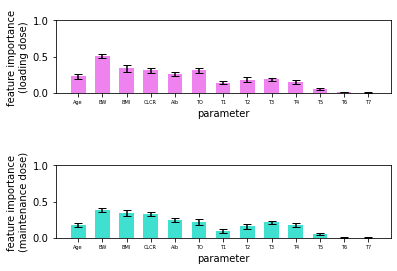

In [6]:
#TEIC-module 5.3 (permutation importance)

#enter the filepath3 and 4 before running the program

filepath1 ="../dataset/TEIC_data(expert_non-ICU)(TEIC-table3).csv"#filepath to the dataset (TEIC-table3)
filepath2 ="../weight parameter/external validation (expertML)"#filepath to the folder containing weight parameters
filepath3 =""#filepath to the folder where to save the result (csv)
filepath4 =""#filepath to the folder where to save the result (figure)


from pyparsing.helpers import Keyword
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as st

def one_hot_encoding(x):
    unique = list(np.unique(x))
    for i in unique:
        x = np.where(x == i, unique.index(i), x)
    x = np.ravel(x).astype(int)
    one_hot = np.eye(len(np.unique(x)))[x]
    return unique, one_hot    

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) #oveflow
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.res

def sigmoid(x):
    return 1 / (1 + np.exp(-x))  

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)


def change_key(dic, ls):#change key in dic to ls
    dic_new = {}
    for value, key in zip(dic.values(),ls):
        dic_new[key]=value
    return dic_new

def df_list_to_value(df,ln):#ln = the length of the list
    for i in df.columns.values:
        ls = df.at[0,i]
        for j in range(ln):
            df.at[j,i] = ls[j]
    return df

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:input, t:output
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:input, t:output
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

    def permuted(self, x):
        dic = {}
        for i in range(x.shape[1]):
            permuted_np = x.copy()
            permuted_np[:,i] = np.random.permutation(x[:,i])
            dic[i]=permuted_np
        return(dic)

    def pimp(self, x, t, n):
        permuted_scores = {}
        score_difference = {}
        # base score
        base_score = self.accuracy(x, t)
        # score after shuffling
        for i in range(x.shape[1]):#empty list for each parameter
            permuted_scores[i]=[]
            score_difference[i]=[]

        for j in range(n):
            self.permuted(x)
            for column_id, permuted_x_param in self.permuted(x).items():
                permuted_score = self.accuracy(permuted_x_param, t)
                permuted_scores[column_id].append(permuted_score)
                score_difference[column_id].append(base_score-permuted_score)
        return base_score, permuted_scores, score_difference
    
def score_difference_statistics(dic):
    dic_stat_mean = {}
    dic_stat_stdev = {}
    for column_id, param in dic.items():
        dic_stat_mean[column_id] = st.mean(param)
        dic_stat_stdev[column_id] = st.stdev(param)
    return dic_stat_mean,dic_stat_stdev

data = pd.read_csv(filepath1)#experts' data

param_list1=["Age","body weight","BMI","Creatinine clearance","Alb","TO"]
param_list2 = ["T1","T2","T3","T4","T5","T6","T7"]
param_list3 = ["index"]
param_whole = param_list1+param_list2

parameter1 = np.array(data[param_list1]).astype(np.float32) #patameter1 (numerical)
parameter2 = np.array(data[param_list2]) #patameter2 (binary)
ID = np.array(data[param_list3])
loading = np.array(data[["loading dose"]])
maintenance = np.array(data[["maintenance dose"]])
TDM = np.array(data[["TDM","TDM exclusion criteria"]])

#transform loading to one-hot encoding
ll, loading_one_hot = one_hot_encoding(loading)

#transform maintenance to one-hot encoding
lm, maintenance_one_hot = one_hot_encoding(maintenance)

sc = StandardScaler()
sc.fit(parameter1)
parameter1_scaler = sc.transform(parameter1)
parameter_scaler = np.concatenate([parameter1_scaler, parameter2], 1)

#loading
network_loading = TwoLayerNet(input_size=len(param_whole), hidden_size=15, output_size=len(np.unique(loading_model)))

#paramter incorporation
for key in ('W1', 'b1', 'W2', 'b2'):
    network_loading.params[key] = np.load(str(filepath2)+"/loading.param({}_whole_non-ICU_lr_0.1).npy".format(key))

pred_loading_one_hot = network_loading.predict(parameter_scaler)
pm_score_diff_ld = network_loading.pimp(parameter_scaler,loading_one_hot,20)[2]
pm_score_diff_ld = change_key(pm_score_diff_ld, param_whole) #change key (1,2,3...) to parameter names

print("permuted importance(loading); mean and stdev")
print(score_difference_statistics(pm_score_diff_ld))

#graph
plt.subplots_adjust(wspace=0.4, hspace=1)#graph adjust


x = ["Age","BW","BMI","CLCR","Alb","TO","T1","T2","T3","T4","T5","T6","T7"]
y_ld = [i for i in score_difference_statistics(pm_score_diff_ld)[0].values()]
err_ld = [i for i in score_difference_statistics(pm_score_diff_ld)[1].values()]

plt.subplot(211)
plt.bar(x, y_ld, width=0.6, linewidth = 2, color = "violet", yerr=err_ld, capsize=4)
plt.xticks(x, fontsize=5)
plt.ylim(0,1.0)
plt.xlabel("parameter")
plt.ylabel("feature importance \n(loading dose)")

print("\n\n")
df_ld = pd.DataFrame([pm_score_diff_ld])
df_list_to_value(df_ld,len(df_ld.iat[0,0]))
display(df_ld)

df_ld.to_csv(str(filepath3)+"/feature_importance_ld_non-ICU.csv", index=False)

#maintenance
network_maintenance = TwoLayerNet(input_size=len(param_whole), hidden_size=15, output_size=len(np.unique(maintenance_model)))

#parameter incorporation
for key in ('W1', 'b1', 'W2', 'b2'):
    network_maintenance.params[key] = np.load(str(filepath2)+"/maintenance.param({}_whole_non-ICU_lr_0.1).npy".format(key))

pred_maintenance_one_hot = network_maintenance.predict(parameter_scaler)
pm_score_diff_mn = network_maintenance.pimp(parameter_scaler,maintenance_one_hot,20)[2]
pm_score_diff_mn = change_key(pm_score_diff_mn, param_whole) #change key (1,2,3...) to parameter names


print("permuted importance (maintenance); mean and stdev")
print(score_difference_statistics(pm_score_diff_mn))

#graph
x = ["Age","BW","BMI","CLCR","Alb","TO","T1","T2","T3","T4","T5","T6","T7"]
y_mn = [i for i in score_difference_statistics(pm_score_diff_mn)[0].values()]
err_mn = [i for i in score_difference_statistics(pm_score_diff_mn)[1].values()]

plt.subplot(212)
plt.bar(x, y_mn, width=0.6, linewidth = 2, color = "turquoise", yerr=err_ld, capsize=4)
plt.xticks(x, fontsize=5)
plt.ylim(0,1.0)
plt.xlabel("parameter")
plt.ylabel("feature importance \n(maintenance dose)")

print("\n\n")
df_mn = pd.DataFrame([pm_score_diff_mn])
df_list_to_value(df_mn,len(df_mn.iat[0,0]))
display(df_mn)

df_mn.to_csv(str(filepath3)+"/feature_importance_mn_non-ICU.csv", index=False)

plt.savefig(str(filepath4)+"/TEIC_figureC.png",format="png", dpi=300)